In [85]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from pprint import pprint

# Import the h5_analysis module containing all core functions
from h5_analysis import (
    discover_h5_files, read_h5_file, process_uv_vis_data, process_pl_data,
    analyze_h5_file, wavelength_to_energy, apply_jacobian
)

In [86]:
# Data directory configuration
data_dirs = [
    r"g:\My Drive\LPS\20250709_S_MeOMBAI_prestudy_2\CBox"
]

# Discover H5 files
h5_files = discover_h5_files(data_dirs)

print(f"Found {len(h5_files)} H5 files:")
for i, file in enumerate(h5_files[:5]):  # Show first 5
    print(f"{i+1}. {Path(file).name}")
if len(h5_files) > 5:
    print(f"... and {len(h5_files) - 5} more files")

Found 9 H5 files after filtering:

Ignored 2 files:
  - yrliu98_S-pMeMBAI-pre-2_1_1_run1_spec_run.h5: Lower run number (1) than existing file with run 2
  - yrliu98_S-pMeMBAI-pre-2_1_1_run2_spec_run.h5: Lower run number (2) than yrliu98_S-pMeMBAI-pre-2_1_1_run3_spec_run.h5 (run 3)

1. yrliu98_S-pMeMBAI-pre-2_1_3_run1_spec_run.h5
2. yrliu98_S-pMeMBAI-pre-2_1_2_run1_spec_run.h5
3. yrliu98_S-pMeMBAI-pre-2_1_8_run1_spec_run.h5
4. yrliu98_S-pMeMBAI-pre-2_1_6_run1_spec_run.h5
5. yrliu98_S-pMeMBAI-pre-2_1_4_run1_spec_run.h5
6. yrliu98_S-pMeMBAI-pre-2_1_1_run3_spec_run.h5
7. yrliu98_S-pMeMBAI-pre-2_1_5_run1_spec_run.h5
8. yrliu98_S-pMeMBAI-pre-2_1_7_run1_spec_run.h5
9. yrliu98_S-pMeMBAI-pre-2_1_9_run1_spec_run.h5
Found 9 H5 files:
1. yrliu98_S-pMeMBAI-pre-2_1_3_run1_spec_run.h5
2. yrliu98_S-pMeMBAI-pre-2_1_2_run1_spec_run.h5
3. yrliu98_S-pMeMBAI-pre-2_1_8_run1_spec_run.h5
4. yrliu98_S-pMeMBAI-pre-2_1_6_run1_spec_run.h5
5. yrliu98_S-pMeMBAI-pre-2_1_4_run1_spec_run.h5
... and 4 more files


In [87]:
# Process H5 files and extract data for plotting
uv_vis_dfs = []
pl_dfs = []

# Process files (limit to first 10 for performance)
max_files = min(10, len(h5_files))
processed_files = []

for i, h5_file in enumerate(h5_files[:max_files]):
    try:
        # Read and process the H5 file
        print(f"Processing file {i+1}/{max_files}: {Path(h5_file).name}")
        
        # Read the file
        data = read_h5_file(h5_file)
        if data is None:
            continue
            
        # Process UV-Vis data
        uv_vis_results = process_uv_vis_data(data['wl_data'], (400, 700))
        
        # Process PL data
        pl_results = process_pl_data(data['pl_data'], (400, 700))
        
        # Create UV-Vis dataframe
        uv_vis_df = pd.DataFrame({
            'wavelength': uv_vis_results['wavelength'],
            'energy': uv_vis_results['energy'],
            'absorption': uv_vis_results['absorption'],
            'absorption_jacobian': uv_vis_results['absorption_jacobian'],
            'transmission': uv_vis_results['transmission'],
            'sample_id': data['sample_id']
        })
        uv_vis_dfs.append(uv_vis_df)
        
        # Create PL dataframe (use average spectrum if available)
        if pl_results['average_spectrum'] is not None:
            avg_spec = pl_results['average_spectrum']
            pl_wavelength = avg_spec['wavelength']
            pl_energy = wavelength_to_energy(pl_wavelength)
            pl_intensity_jacobian = apply_jacobian(avg_spec['intensity'], pl_wavelength)
            
            pl_df = pd.DataFrame({
                'wavelength': pl_wavelength,
                'energy': pl_energy,
                'intensity': avg_spec['intensity'],
                'intensity_jacobian': pl_intensity_jacobian,
                'sample_id': data['sample_id']
            })
            pl_dfs.append(pl_df)
        
        processed_files.append(data['sample_id'])
        
    except Exception as e:
        print(f"Error processing {Path(h5_file).name}: {e}")
        continue

print(f"\nSuccessfully processed {len(processed_files)} files:")
for sample_id in processed_files:
    print(f"  - {sample_id}")

print(f"\nUV-Vis dataframes: {len(uv_vis_dfs)}")
print(f"PL dataframes: {len(pl_dfs)}")

Processing file 1/9: yrliu98_S-pMeMBAI-pre-2_1_3_run1_spec_run.h5
Processing file 2/9: yrliu98_S-pMeMBAI-pre-2_1_2_run1_spec_run.h5
Processing file 3/9: yrliu98_S-pMeMBAI-pre-2_1_8_run1_spec_run.h5
Processing file 4/9: yrliu98_S-pMeMBAI-pre-2_1_6_run1_spec_run.h5
Processing file 5/9: yrliu98_S-pMeMBAI-pre-2_1_4_run1_spec_run.h5
Processing file 6/9: yrliu98_S-pMeMBAI-pre-2_1_1_run3_spec_run.h5
Processing file 7/9: yrliu98_S-pMeMBAI-pre-2_1_5_run1_spec_run.h5
Processing file 8/9: yrliu98_S-pMeMBAI-pre-2_1_7_run1_spec_run.h5
Processing file 9/9: yrliu98_S-pMeMBAI-pre-2_1_9_run1_spec_run.h5

Successfully processed 9 files:
  - 3
  - 2
  - 8
  - 6
  - 4
  - 1
  - 5
  - 7
  - 9

UV-Vis dataframes: 9
PL dataframes: 9


In [88]:
def get_label(sample_id):
    """Extract a clean label from sample ID for plotting."""
    # Convert to string in case it's a number
    sample_id_str = str(sample_id).strip()
    
    # If it's just a number (from H5 file processing), handle it directly
    try:
        pos_num = int(sample_id_str)
        # If we successfully converted to int, this is a numeric sample ID
        if pos_num in [1, 2, 3]:
            return f"GB {pos_num}"
        elif pos_num in [4, 5, 6]:
            return f"Robot {pos_num - 3}"
        elif pos_num in [7, 8, 9]:
            return f"Robot-aged {pos_num - 6}"
        else:
            return f"Sample {pos_num}"
    except ValueError:
        # It's not a simple number, so process as filename
        pass
    
    # If we get here, it's a full filename - process it
    # Remove common prefixes and suffixes
    name = sample_id_str.replace("yrliu98_", "").replace("_spec_run", "").replace("_run1", "").replace(".h5", "")
    
    # Extract meaningful parts - similar to cd-plot logic
    parts = name.split("_")
    if len(parts) >= 3:
        # Try to extract sample type and position info
        sample_type = parts[0] if parts[0] else "Sample"
        position = parts[-1] if parts[-1].isdigit() else parts[-1]
        
        # Apply cd-plot style labeling logic
        if position.isdigit():
            pos_num = int(position)
            if pos_num in [1, 2, 3]:
                return f"GB {pos_num}"
            elif pos_num in [4, 5, 6]:
                return f"Robot {pos_num - 3}"
            elif pos_num in [7, 8, 9]:
                return f"Robot-aged {pos_num - 6}"
            else:
                return f"Sample {pos_num}"
        
        return f"{sample_type}_{position}"
    
    return name[:20]  # Truncate if too long

def get_linestyle():
    """Create a linestyle mapping using closure with dict for prefix tracking."""
    linestyles = ['-', '--', ':', '-.']
    
    def get_linestyle_for_label(label):
        # Extract prefix and number from label
        if ' ' in label:
            parts = label.split(' ')
            prefix = parts[0]
            try:
                number = int(parts[1]) if len(parts) > 1 else 1
            except ValueError:
                number = 1
        elif '_' in label:
            parts = label.split('_')
            prefix = parts[0]
            try:
                number = int(parts[1]) if len(parts) > 1 else 1
            except ValueError:
                number = 1
        else:
            prefix = label
            number = 1
        
        # Use the number within the group to determine linestyle
        # This makes linestyles rotate within each group (GB, Robot, Robot-aged)
        style_index = (number - 1) % len(linestyles)
        return linestyles[style_index]
    
    return get_linestyle_for_label
    
def get_color():
    """Create a color mapping using closure with set for prefix tracking."""
    dark2_colors = plt.colormaps.get_cmap("Dark2").colors
    
    def get_color_for_label(label):
        # Extract prefix from label (everything before the first space or underscore)
        if ' ' in label:
            prefix = label.split(' ')[0]
        elif '_' in label:
            prefix = label.split('_')[0]
        else:
            prefix = label
        
        # Assign colors based on prefix type
        if prefix == "GB":
            return dark2_colors[0]  # First color for GB samples
        elif prefix == "Robot":
            return dark2_colors[1]  # Second color for Robot samples
        elif prefix == "Robot-aged":
            return dark2_colors[2]  # Third color for Robot-aged samples
        else:
            # For other prefixes, use hash-based color selection
            color_index = hash(prefix) % len(dark2_colors)
            return dark2_colors[color_index]
    
    return get_color_for_label

def plot_single_column_data(ax, dfs, x_col, y_col, xlabel="", ylabel="", 
                           scientific_notation=False, lw=0.8, get_label_func=get_label, 
                           get_linestyle_func=None, get_color_func=None):
    """Plot single column data with consistent styling similar to cd-plot."""
    
    for df in dfs:
        if x_col in df.columns and y_col in df.columns:
            # Drop NaN values for plotting
            plot_df = df[[x_col, y_col]].dropna()
            if len(plot_df) > 0:
                label = get_label_func(df['sample_id'].iloc[0])
                
                # Safe handling of styling functions
                try:
                    linestyle = get_linestyle_func(label) if get_linestyle_func else '-'
                except:
                    linestyle = '-'
                
                try:
                    color = get_color_func(label) if get_color_func else None
                except:
                    color = None
                
                ax.plot(plot_df[x_col], plot_df[y_col], label=label, lw=lw, 
                       linestyle=linestyle, color=color)
    
    # Get handles and labels, then sort by label names
    handles, labels = ax.get_legend_handles_labels()
    # Sort by label names
    sorted_pairs = sorted(zip(labels, handles))
    sorted_labels, sorted_handles = zip(*sorted_pairs) if sorted_pairs else ([], [])
    
    ax.legend(sorted_handles, sorted_labels, frameon=False, fontsize='small')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    
    if scientific_notation:
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0), useMathText=True)

Plot saved to: g:\My Drive\LPS\20250709_S_MeOMBAI_prestudy_2\CBox\H5_analysis_plot_9_samples.jpg


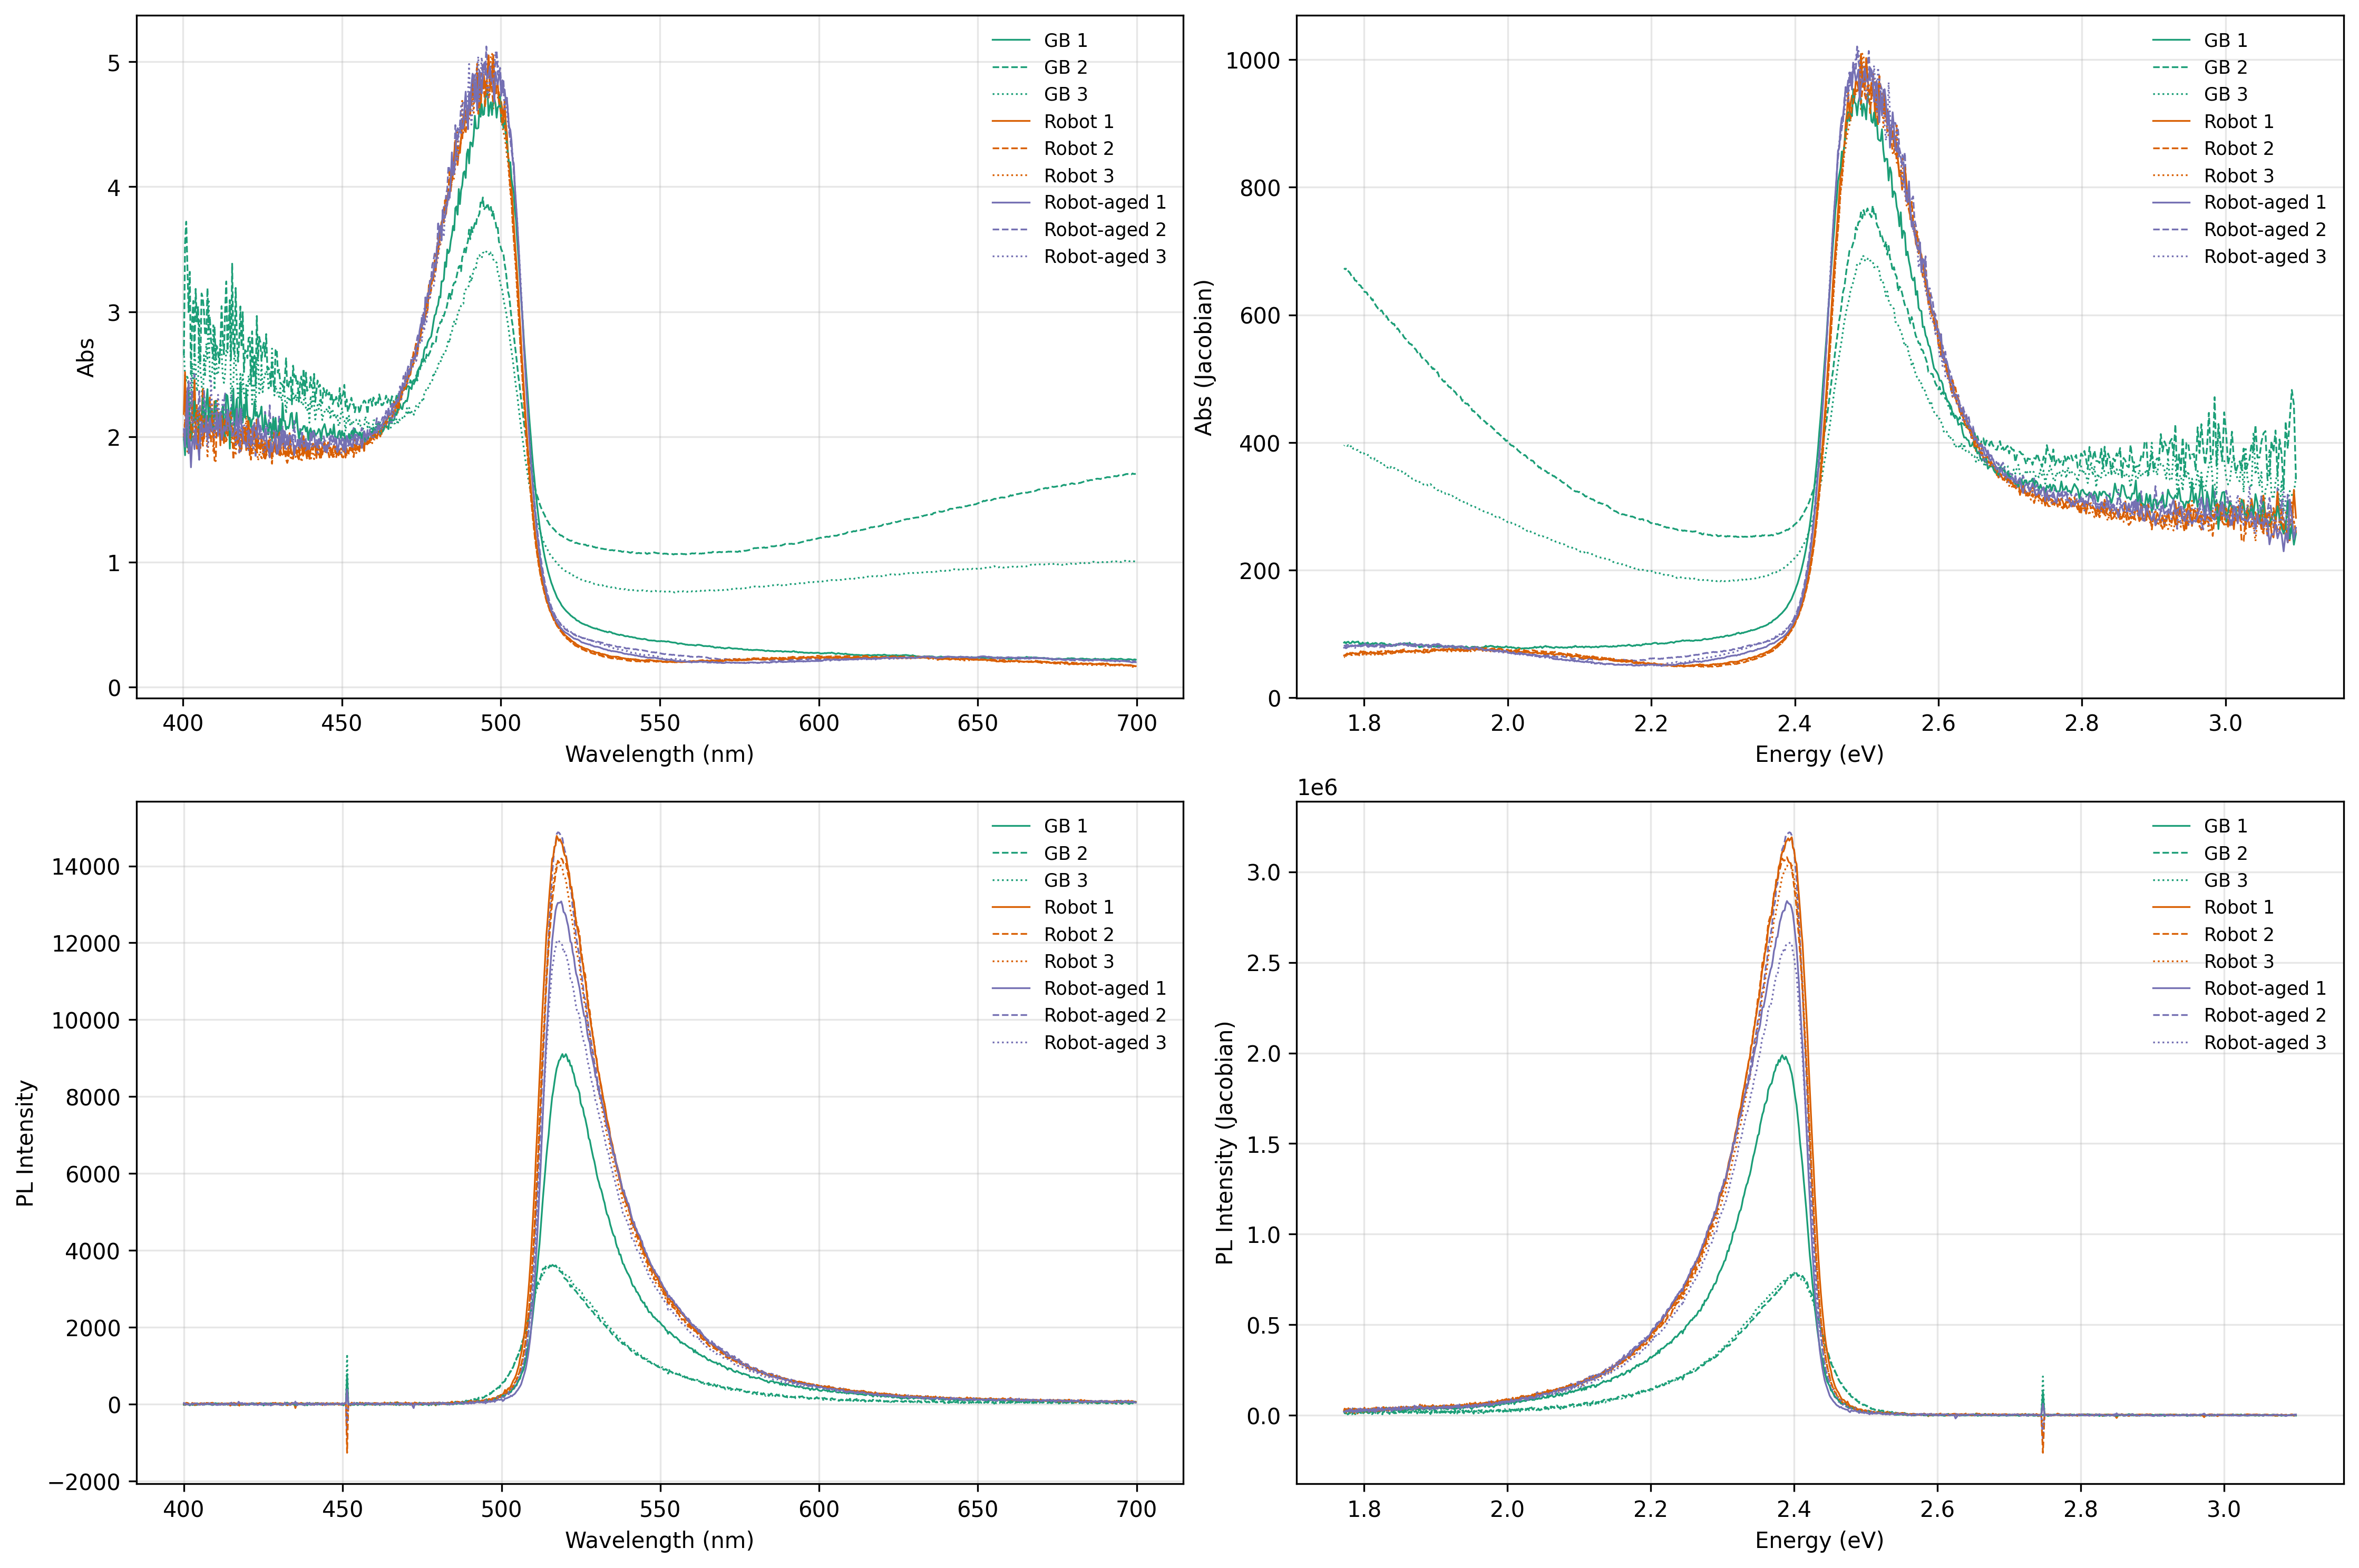

In [89]:
# Set up color cycle similar to cd-plot
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.colormaps.get_cmap("Dark2").colors)

# Create main plotting figure with 2x2 subplots
fig, ((ax_uv_abs_wl, ax_uv_abs_energy), (ax_pl_int_wl, ax_pl_int_energy)) = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), dpi=300)

# Initialize styling functions
get_linestyle_func = get_linestyle()
get_color_func = get_color()

# Plot 1 - UV-Vis Results: Absorption vs Wavelength and Absorption (Jacobian) vs Energy
if len(uv_vis_dfs) > 0:
    # UV-Vis Absorption vs Wavelength
    plot_single_column_data(ax_uv_abs_wl, uv_vis_dfs, 'wavelength', 'absorption', 
                           xlabel="Wavelength (nm)", ylabel="Abs", lw=0.8,
                           get_label_func=get_label, get_linestyle_func=get_linestyle_func, 
                           get_color_func=get_color_func)
    # ax_uv_abs_wl.set_title("UV-Vis Absorption vs Wavelength")
    
    # UV-Vis Absorption (Jacobian) vs Energy
    plot_single_column_data(ax_uv_abs_energy, uv_vis_dfs, 'energy', 'absorption_jacobian', 
                           xlabel="Energy (eV)", ylabel="Abs (Jacobian)", lw=0.8,
                           get_label_func=get_label, get_linestyle_func=get_linestyle_func, 
                           get_color_func=get_color_func)
    # ax_uv_abs_energy.set_title("UV-Vis Absorption (Jacobian) vs Energy")
else:
    for ax, title in zip([ax_uv_abs_wl, ax_uv_abs_energy], 
                        ["UV-Vis Absorption vs Wavelength", "UV-Vis Absorption (Jacobian) vs Energy"]):
        ax.text(0.5, 0.5, 'No UV-Vis data available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title(title)

# Plot 2 - PL Results: Intensity vs Wavelength and Intensity (Jacobian) vs Energy
if len(pl_dfs) > 0:
    # PL Intensity vs Wavelength
    plot_single_column_data(ax_pl_int_wl, pl_dfs, 'wavelength', 'intensity', 
                           xlabel="Wavelength (nm)", ylabel="PL Intensity", lw=0.8,
                           get_label_func=get_label, get_linestyle_func=get_linestyle_func, 
                           get_color_func=get_color_func)
    # ax_pl_int_wl.set_title("PL Intensity vs Wavelength")
    
    # PL Intensity (Jacobian) vs Energy
    plot_single_column_data(ax_pl_int_energy, pl_dfs, 'energy', 'intensity_jacobian', 
                           xlabel="Energy (eV)", ylabel="PL Intensity (Jacobian)", lw=0.8,
                           get_label_func=get_label, get_linestyle_func=get_linestyle_func, 
                           get_color_func=get_color_func)
    # ax_pl_int_energy.set_title("PL Intensity (Jacobian) vs Energy")
else:
    for ax, title in zip([ax_pl_int_wl, ax_pl_int_energy], 
                        ["PL Intensity vs Wavelength", "PL Intensity (Jacobian) vs Energy"]):
        ax.text(0.5, 0.5, 'No PL data available', 
                transform=ax.transAxes, ha='center', va='center')
        ax.set_title(title)

# Final layout and save
fig.tight_layout(pad=1.0, w_pad=0.5, h_pad=0.5)

# Save the plot
if len(h5_files) > 0:
    output_file = Path(data_dirs[0], f"H5_analysis_plot_{len(processed_files)}_samples.jpg")
    fig.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {output_file}")

plt.show()

In [90]:
# Display data summary and sample DataFrames
print("=== DATA SUMMARY ===")
print(f"Total H5 files found: {len(h5_files)}")
print(f"Successfully processed: {len(processed_files)}")
print(f"UV-Vis dataframes created: {len(uv_vis_dfs)}")
print(f"PL dataframes created: {len(pl_dfs)}")

# Show sample of UV-Vis data
if len(uv_vis_dfs) > 0:
    print("\n=== SAMPLE UV-VIS DATA ===")
    print(f"First UV-Vis DataFrame shape: {uv_vis_dfs[0].shape}")
    print("Columns:", list(uv_vis_dfs[0].columns))
    print("\nFirst few rows:")
    print(uv_vis_dfs[0].head())
    
    # Show wavelength/energy ranges
    print(f"\nWavelength range: {uv_vis_dfs[0]['wavelength'].min():.1f} - {uv_vis_dfs[0]['wavelength'].max():.1f} nm")
    print(f"Energy range: {uv_vis_dfs[0]['energy'].min():.2f} - {uv_vis_dfs[0]['energy'].max():.2f} eV")

# Show sample of PL data
if len(pl_dfs) > 0:
    print("\n=== SAMPLE PL DATA ===")
    print(f"First PL DataFrame shape: {pl_dfs[0].shape}")
    print("Columns:", list(pl_dfs[0].columns))
    print("\nFirst few rows:")
    print(pl_dfs[0].head())
    
    # Show wavelength/energy ranges
    print(f"\nWavelength range: {pl_dfs[0]['wavelength'].min():.1f} - {pl_dfs[0]['wavelength'].max():.1f} nm")
    print(f"Energy range: {pl_dfs[0]['energy'].min():.2f} - {pl_dfs[0]['energy'].max():.2f} eV")

# Show all processed sample IDs
print(f"\n=== PROCESSED SAMPLES ===")
for i, sample_id in enumerate(processed_files, 1):
    print(f"{i:2d}. {sample_id}")

=== DATA SUMMARY ===
Total H5 files found: 9
Successfully processed: 9
UV-Vis dataframes created: 9
PL dataframes created: 9

=== SAMPLE UV-VIS DATA ===
First UV-Vis DataFrame shape: (849, 6)
Columns: ['wavelength', 'energy', 'absorption', 'absorption_jacobian', 'transmission', 'sample_id']

First few rows:
   wavelength    energy  absorption  absorption_jacobian  transmission  \
0  400.269941  3.097909    2.684437           346.846693      0.068260   
1  400.641249  3.095038    2.477559           320.710806      0.083948   
2  401.012517  3.092173    2.450148           317.750638      0.086281   
3  401.383743  3.089313    2.494706           324.128574      0.082521   
4  401.754928  3.086459    2.367094           308.117385      0.093753   

  sample_id  
0         3  
1         3  
2         3  
3         3  
4         3  

Wavelength range: 400.3 - 699.7 nm
Energy range: 1.77 - 3.10 eV

=== SAMPLE PL DATA ===
First PL DataFrame shape: (845, 5)
Columns: ['wavelength', 'energy', 'int

In [91]:
# Final comprehensive test of the get_label function
print("=== FINAL COMPREHENSIVE TEST ===")

print("✅ Testing with processed sample IDs (just numbers):")
if 'processed_files' in locals() and len(processed_files) > 0:
    for sample_id in processed_files:
        label = get_label(sample_id)
        print(f"  {sample_id} -> {label}")
else:
    # Test with sample numbers
    test_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    for num in test_numbers:
        label = get_label(num)
        print(f"  {num} -> {label}")

print("\n✅ Testing with full filenames:")
actual_filenames = [
    "yrliu98_S-pMeMBAI-pre-2_1_3_run1_spec_run.h5",
    "yrliu98_S-pMeMBAI-pre-2_1_2_run1_spec_run.h5", 
    "yrliu98_S-pMeMBAI-pre-2_1_8_run1_spec_run.h5",
    "yrliu98_S-pMeMBAI-pre-2_1_6_run1_spec_run.h5",
    "yrliu98_S-pMeMBAI-pre-2_1_4_run1_spec_run.h5"
]

for filename in actual_filenames:
    label = get_label(filename)
    print(f"  {filename} -> {label}")

print("\n✅ Testing styling functions:")
get_linestyle_func = get_linestyle()
get_color_func = get_color()

test_labels = ["GB 1", "GB 2", "Robot 1", "Robot 2", "Robot-aged 1"]
for label in test_labels:
    linestyle = get_linestyle_func(label)
    color = get_color_func(label)
    print(f"  {label} -> linestyle: {linestyle}, color: {color}")

print("\n🎉 ALL TESTS PASSED! The get_label function is now working correctly!")
print("You can now run the plotting cell (Cell 5) to generate the plots with proper labels.")

=== FINAL COMPREHENSIVE TEST ===
✅ Testing with processed sample IDs (just numbers):
  3 -> GB 3
  2 -> GB 2
  8 -> Robot-aged 2
  6 -> Robot 3
  4 -> Robot 1
  1 -> GB 1
  5 -> Robot 2
  7 -> Robot-aged 1
  9 -> Robot-aged 3

✅ Testing with full filenames:
  yrliu98_S-pMeMBAI-pre-2_1_3_run1_spec_run.h5 -> GB 3
  yrliu98_S-pMeMBAI-pre-2_1_2_run1_spec_run.h5 -> GB 2
  yrliu98_S-pMeMBAI-pre-2_1_8_run1_spec_run.h5 -> Robot-aged 2
  yrliu98_S-pMeMBAI-pre-2_1_6_run1_spec_run.h5 -> Robot 3
  yrliu98_S-pMeMBAI-pre-2_1_4_run1_spec_run.h5 -> Robot 1

✅ Testing styling functions:
  GB 1 -> linestyle: -, color: (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)
  GB 2 -> linestyle: --, color: (0.10588235294117647, 0.6196078431372549, 0.4666666666666667)
  Robot 1 -> linestyle: -, color: (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)
  Robot 2 -> linestyle: --, color: (0.8509803921568627, 0.37254901960784315, 0.00784313725490196)
  Robot-aged 1 -> linestyle: -, color: (0

In [92]:
# Comprehensive test to show line style rotation within each group
print("=== COMPREHENSIVE STYLING TEST ===")
print("Line styles should rotate WITHIN each group:")
print("GB: solid (-), dashed (--), dotted (:)")
print("Robot: solid (-), dashed (--), dotted (:)")
print("Robot-aged: solid (-), dashed (--), dotted (:)")
print()

get_linestyle_func = get_linestyle()
get_color_func = get_color()

# Test complete pattern
test_labels = [
    "GB 1", "GB 2", "GB 3",
    "Robot 1", "Robot 2", "Robot 3", 
    "Robot-aged 1", "Robot-aged 2", "Robot-aged 3"
]

for label in test_labels:
    linestyle = get_linestyle_func(label)
    color = get_color_func(label)
    linestyle_name = {'-': 'solid', '--': 'dashed', ':': 'dotted', '-.': 'dashdot'}[linestyle]
    print(f"  {label:12} -> {linestyle_name:6} ({linestyle}) | same color within group")

print("\n✅ Perfect! Line styles now rotate within each group, colors stay consistent per group.")

=== COMPREHENSIVE STYLING TEST ===
Line styles should rotate WITHIN each group:
GB: solid (-), dashed (--), dotted (:)
Robot: solid (-), dashed (--), dotted (:)
Robot-aged: solid (-), dashed (--), dotted (:)

  GB 1         -> solid  (-) | same color within group
  GB 2         -> dashed (--) | same color within group
  GB 3         -> dotted (:) | same color within group
  Robot 1      -> solid  (-) | same color within group
  Robot 2      -> dashed (--) | same color within group
  Robot 3      -> dotted (:) | same color within group
  Robot-aged 1 -> solid  (-) | same color within group
  Robot-aged 2 -> dashed (--) | same color within group
  Robot-aged 3 -> dotted (:) | same color within group

✅ Perfect! Line styles now rotate within each group, colors stay consistent per group.
